In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import ROOT

In [2]:
file = ROOT.TFile.Open("../DetectorSimulation/output/run_20260207205200.110647_t6.root")

OSError: Failed to open file ../DetectorSimulation/output/run_20260207205200.110647_t6.root

Error in <TFile::TFile>: file /Users/parkinpham/Programming/Physics/B8_Project/Analysis/../DetectorSimulation/output/run_20260207205200.110647_t6.root does not exist


In [ ]:
hits = file.Get("hits")
hits.Print()

******************************************************************************
*Tree    :hits      : Energy deposit and position                            *
*Entries :       65 : Total =            7355 bytes  File  Size =       3081 *
*        :          : Tree compression factor =   1.00                       *
******************************************************************************
*Br    0 :Energy    : Double_t hits                                          *
*Entries :       65 : Total  Size=       1439 bytes  One basket in memory    *
*Baskets :        0 : Basket Size=      32000 bytes  Compression=   1.00     *
*............................................................................*
*Br    1 :PositionX : Double_t hits                                          *
*Entries :       65 : Total  Size=       1454 bytes  One basket in memory    *
*Baskets :        0 : Basket Size=      32000 bytes  Compression=   1.00     *
*...................................................

In [ ]:
tracks = file.Get("tracks")
tracks.Print()

******************************************************************************
*Tree    :tracks    : Track parameters                                       *
*Entries :       14 : Total =            7922 bytes  File  Size =       1721 *
*        :          : Tree compression factor =   1.00                       *
******************************************************************************
*Br    0 :VertexPositionX : Double_t tracks                                  *
*Entries :       14 : Total  Size=        878 bytes  One basket in memory    *
*Baskets :        0 : Basket Size=      32000 bytes  Compression=   1.00     *
*............................................................................*
*Br    1 :VertexPositionY : Double_t tracks                                  *
*Entries :       14 : Total  Size=        878 bytes  One basket in memory    *
*Baskets :        0 : Basket Size=      32000 bytes  Compression=   1.00     *
*...................................................

In [ ]:
tracks.Scan("ParticleID:Charge;MomentumX:MomentumY:MomentumZ")

14

************************************************************
*    Row   * ParticleI * Charge;Mo * MomentumY * MomentumZ *
************************************************************
*        0 *      2212 *         1 * -1318.635 * 2209.6729 *
*        1 *        22 *         0 * -0.432662 * -0.284425 *
*        2 *        22 *         0 * 19.831738 * -5.966727 *
*        3 *        22 *         0 * 18.276542 * 798.85399 *
*        4 *      -211 *        -1 * 1.8189677 * 15318.858 *
*        5 *        22 *         0 * -72.67674 * 30039.124 *
*        6 *        11 *        -1 * 9787.4898 * -13532.05 *
*        7 *      -321 *        -1 * -2175.957 * 2308.5949 *
*        8 *        22 *         0 * -95.75283 * 1657.9805 *
*        9 *       211 *         1 * -1129.897 * 2204.8971 *
*       10 *       321 *         1 * -1446.599 * 1639.2858 *
*       11 *        22 *         0 * -35.38172 * 48.121129 *
*       12 *        11 *        -1 * -514.3403 * 1184.9337 *
*       13 *       321 *

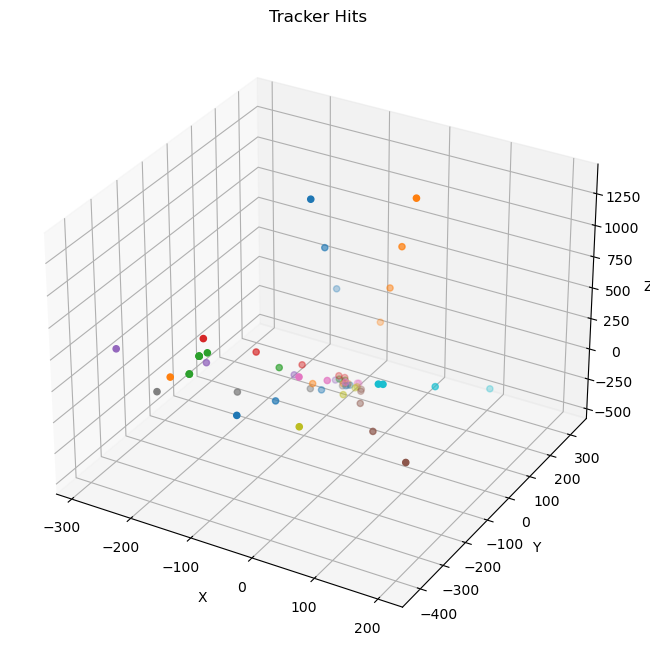

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

num_hits = hits.GetEntries()

x = np.zeros(num_hits)
y = np.zeros(num_hits)
z = np.zeros(num_hits)

trackHits = {}

for i in range(num_hits):
    hits.GetEntry(i)
    x[i] = hits.PositionX
    y[i] = hits.PositionY
    z[i] = hits.PositionZ
    trackID = hits.TrackID
    if trackID not in trackHits:
        trackHits[trackID] = []
    trackHits[trackID].append((hits.PositionX, hits.PositionY, hits.PositionZ))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Tracker Hits')

for track in trackHits.values():
    x, y, z = zip(*track)
    ax.scatter(x, y, z)

plt.show()

# First we cheat and skip the track finding step, and simply fit tracks

In [ ]:
for track in trackHits:
    print(f"Track ID: {track}, Number of hits: {len(trackHits[track])}")

Track ID: 25, Number of hits: 5
Track ID: 24, Number of hits: 4
Track ID: 53, Number of hits: 12
Track ID: 22, Number of hits: 5
Track ID: 20, Number of hits: 5
Track ID: 19, Number of hits: 5
Track ID: 18, Number of hits: 5
Track ID: 15, Number of hits: 5
Track ID: 14, Number of hits: 4
Track ID: 13, Number of hits: 4
Track ID: 10, Number of hits: 3
Track ID: 4, Number of hits: 4
Track ID: 1, Number of hits: 4


In [ ]:
# Kasa method

def circle_fit(x, y):
    M = np.vstack([x, y, np.ones_like(x)]).T
    b = -(x*x + y*y)
    p, *_ = np.linalg.lstsq(M, b, rcond=None)
    A, B, C = p
    x_c = -A/2.0
    y_c = -B/2.0
    R = np.sqrt(x_c ** 2 + y_c ** 2 - C)
    return x_c, y_c, R

In [ ]:
# compute sum over cross product of successive segments in xy

def curvature_sign(x, y):
    cross_z = 0
    for i in range(1, len(x) - 1):
        x1, y1 = x[i] - x[i-1], y[i] - y[i-1]
        x2, y2 = x[i+1] - x[i], y[i+1] - y[i]
        cross_z += x1 * y2 - y1 * x2
    return np.sign(cross_z) if cross_z != 0 else 1.0

In [ ]:
def helix(phi, xc, yc, R, tanl, z0, phi0):
    x = xc + R * np.cos(phi)
    y = yc + R * np.sin(phi)
    z = z0 + tanl * R * (phi - phi0)
    return x, y, z

In [ ]:
# Fit helix parameters to given 3D points, returning (xc, yc, R, tanl, z0, sign)
# x(phi) = xc + R cos(phi)
# y(phi) = yc + R sin(phi)
# z(phi) = z0 + tanl * R * (phi - phi0)

def fit_helix(x, y, z, Bz=1.0, straight_thresh_R=1e6):
    xc, yc, R = circle_fit(x, y)

    # if radius is extremely large, fallback to straight-line fit
    # if R > straight_thresh_R:
    #     A = np.vstack([z, np.ones_like(z)]).T
    #     ax, bx = np.linalg.lstsq(A, x, rcond=None)[0]
    #     ay, by = np.linalg.lstsq(A, y, rcond=None)[0]
    #     zmin, zmax = z.min(), z.max()
    #     zs_sample = np.linspace(zmin, zmax, n_points)
    #     xs_sample = ax*zs_sample + bx
    #     ys_sample = ay*zs_sample + by
    #     helix_pts = np.vstack([xs_sample, ys_sample, zs_sample]).T
    #     params = {'type':'line', 'ax':ax, 'ay':ay, 'bx':bx, 'by':by}
    #     return helix_pts, params

    sign = curvature_sign(x, y)

    phi = np.unwrap(np.arctan2(y - yc, x - xc))

    phi0 = phi[0]
    s = R * (phi - phi0)  

    A = np.vstack([s, np.ones_like(s)]).T
    tanl, z0 = np.linalg.lstsq(A, z, rcond=None)[0]

    return xc, yc, R, tanl, z0, sign

NameError: name 'fit_helix_and_sample' is not defined

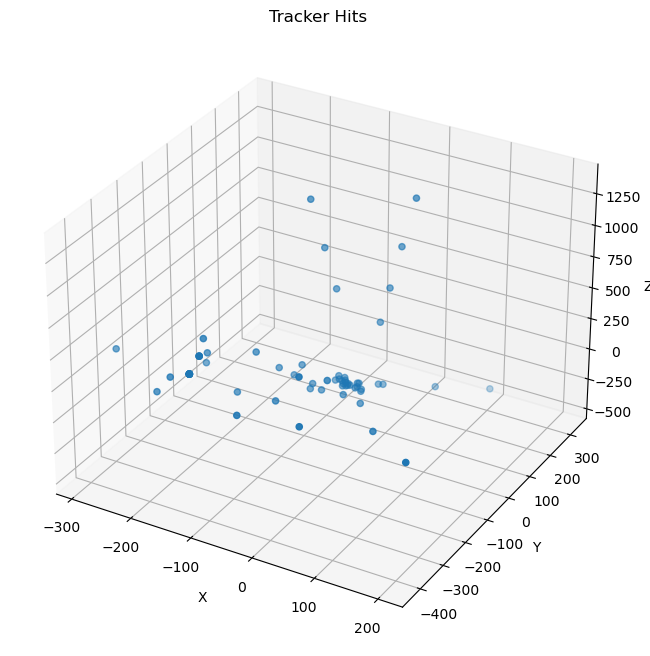

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

num_hits = hits.GetEntries()

x = np.zeros(num_hits)
y = np.zeros(num_hits)
z = np.zeros(num_hits)

trackHits = {}

for i in range(num_hits):
    hits.GetEntry(i)
    x[i] = hits.PositionX
    y[i] = hits.PositionY
    z[i] = hits.PositionZ
    trackID = hits.TrackID
    if trackID not in trackHits:
        trackHits[trackID] = []
    trackHits[trackID].append((hits.PositionX, hits.PositionY, hits.PositionZ))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Tracker Hits')

for trackID, track in trackHits.items():
    ax.scatter(x, y, z)
    if len(track) < 2:
        continue
    x, y, z = zip(*track)
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    helix_pts, params = fit_helix_and_sample(x, y, z, Bz=1.7)
    ax.plot(helix_pts[:,0], helix_pts[:,1], helix_pts[:,2])

plt.show()